## Prepare the data

### 1. Load the fine-tuning data

In [1]:
import json

file_path = "../output/fine_tuning/data/fine_tuning_ready.json"
with open(file_path, "r") as file:
    data = json.load(file)

len(data)

3494

### 2. Load the tokenizer

In [2]:
import sys
sys.path.append('..')

In [3]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/my_dataset_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. System message

The system message will be added to the beginning of each conversation

In [4]:
system_message = "Te llamo Clon de Eduardo para que ayudes a la gente a responder a sus preguntas. Intenta ser amable con ellos, respóndeles con gentileza, o si alguien te molesta, intenta calmarte y no enfadarte con él"
system_entry = {
    "role": "system",
    "content": system_message
}

### 4. Check if block size is not exceeded

In [5]:
max_tokens = 0
block_size = 1024
for conversation in data:
    concatenated_messages = ""
    for message in conversation:
        content = message["content"]
        concatenated_messages += content + "\n"

    tokens = tokenizer.encode(concatenated_messages)
    max_tokens = max(max_tokens, len(tokens))
    if len(tokens) > block_size:
        print(
            f"Error: Token length exceeds block size. Length: {len(tokens)}, Block size: {block_size}")

max_tokens

708

### 5. Add special tokens

![masked_version](../images/masking.svg)

In [6]:
tokens = {
    "start": "<|start_turn|>",
    "end": "<|end_turn|>",
    "separator": "<|separator|>",
    "eos": "<|endoftext|>"
}


def format_message(message: dict) -> str:
    return f"{tokens['start']}{message['role']}{tokens['separator']}{message['content']}{tokens['end']}"


fine_tuning_data = []
for conversation in data:
    concatenated_messages = ""

    for message in conversation:
        role = message["role"]
        if role == "user":
            if len(concatenated_messages) == 0:
                concatenated_messages += format_message({
                    "role": "system",
                    "content": system_message
                })
            concatenated_messages += format_message(message)
        elif role == "assistant":
            concatenated_messages += format_message(message)
            encoded_message = tokenizer.encode(
                text=concatenated_messages + tokens["eos"],
                allowed_special="all"
            )
            fine_tuning_data.append(encoded_message)

In [7]:
len(fine_tuning_data)

13957

In [8]:
tokenizer.decode(fine_tuning_data[0])

'<|start_turn|>assistant<|separator|>Yeyis\nVas a venir?<|end_turn|><|endoftext|>'

In [9]:
tokenizer.decode(fine_tuning_data[1])

'<|start_turn|>assistant<|separator|>Yeyis\nVas a venir?<|end_turn|><|start_turn|>user<|separator|>Siii\nSabes que es NAT?<|end_turn|><|start_turn|>assistant<|separator|>Creo que un tipo de red\nO algo de almacenamiento\nYa llegó sushi<|end_turn|><|endoftext|>'

Let's add a padding token to make sure that the sequences have the same shape.

In [10]:
max_sequence_length = max(
    len(sequence) for sequence in fine_tuning_data)
max_sequence_length

956

In [11]:
import torch
torch.manual_seed(3647)

# The model will ignore the padding tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], max_sequence_length: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, max_sequence_length - len(tensor)),
            # pad=(max_sequence_length - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=fine_tuning_data,
    max_sequence_length=max_sequence_length,
    padding_token=padding_token
)
train_data_tensor.shape

torch.Size([13957, 956])

In [12]:
split_index = int(0.95*len(train_data_tensor))
train_data_split = train_data_tensor[:split_index]
val_data_split = train_data_tensor[split_index:]

train_data_split.shape, val_data_split.shape

(torch.Size([13259, 956]), torch.Size([698, 956]))

### 6. Creat the data loader

In [13]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        masked_y = self.apply_mask_to_target(y)
        return x, masked_y

    def apply_mask_to_target(self, y: torch.Tensor) -> torch.Tensor:
        assistant_turn_tokens = torch.tensor(
            tokenizer.encode(
                "<|start_turn|>assistant<|separator|>",
                allowed_special="all"
            ),
            device=self.device
        )
        sublist_length = len(assistant_turn_tokens)

        # Find the last occurrence of assistant_turn_tokens in y
        # This only works if yoou use right padding
        last_occurrence = -1
        for i in range(len(y) - sublist_length + 1):
            if torch.all(y[i:i+sublist_length] == assistant_turn_tokens):
                last_occurrence = i + sublist_length - 1

        if last_occurrence != -1:
            y[:last_occurrence + 1] = self.padding_token

        return y


batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_split,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_split,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [14]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([8, 956]), torch.Size([8, 956]))

In [15]:
x, y = next(iter(val_loader))
x.shape, y.shape

(torch.Size([8, 956]), torch.Size([8, 956]))

## Fine-tuning

### 1. Load the saved checkpoint

In [16]:
from transformer.model import GPTLanguageModel

block_size = 1024
n_embd = 512
n_head = 32
n_layer = 6
dropout = 0.2
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

36.23425 M parameters


In [17]:
checkpoint_path = "../output/pre_training/run_4/checkpoint_15000.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Generate from the model to make sure that the weights were loaded correctly.

In [18]:
input_tokens = tokenizer.encode("Hola como estas? ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Hola como estas?  Crédito poner23 m desde31 m desde31ti.añ imagen,fica!añ Cuando yiry artefactos habit apa random Ten, so Pan26 dormirás?49 serun salchichas bols?49 ser b Bluetooth gustóhoome21 amigui31 m.ja 🤨🤨�un prior verdad23er canlig, para Servicio RH Zale02dala ocaleraona02dala ocaleraona Keiarita, obli so Pan faltabanMS fin ulti aguía02dala ocaleraona Keiar burbu07 sugi15omeit apa random


### 2. Estimate loss

In [19]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(len(loader))
        for i, (x, y) in enumerate(loader):
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

### 3. Save checkpoints

In [20]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [21]:
from tqdm import tqdm

max_iters = 50
eval_interval = 5
learning_rate = 1e-4
save_interval = 20

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses, val_losses = [], []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in tqdm(
        iterable=enumerate(train_loader),
        desc="Training on batches",
        total=len(train_loader)
    ):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader
            )
            print(
                f"Epoch {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    if iteration % save_interval == 0 or iteration == max_iters - 1:
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=iteration,
            loss=loss.item(),
            file_path=f"../output/fine_tuning/qa/base/run_1/checkpoint_{iteration}.pth"
        )

Training on batches:   0%|          | 0/1658 [00:00<?, ?it/s]

Epoch 0 / step 0: train loss 14.1355, val loss 13.9725


Training on batches:   0%|          | 5/1658 [36:28<95:02:11, 206.98s/it]  

Epoch 0 / step 5: train loss 9.1323, val loss 9.3545


Training on batches:   1%|          | 10/1658 [5:43:54<646:16:32, 1411.77s/it]

Epoch 0 / step 10: train loss 8.2541, val loss 8.5205


Training on batches:   1%|          | 15/1658 [10:12:31<644:18:16, 1411.74s/it] 

Epoch 0 / step 15: train loss 7.5693, val loss 7.7722


Training on batches:   1%|          | 20/1658 [15:07:16<693:08:40, 1523.39s/it] 

Epoch 0 / step 20: train loss 6.9133, val loss 7.1547


Training on batches:   2%|▏         | 25/1658 [19:29:36<1273:18:23, 2807.04s/it]


KeyboardInterrupt: 

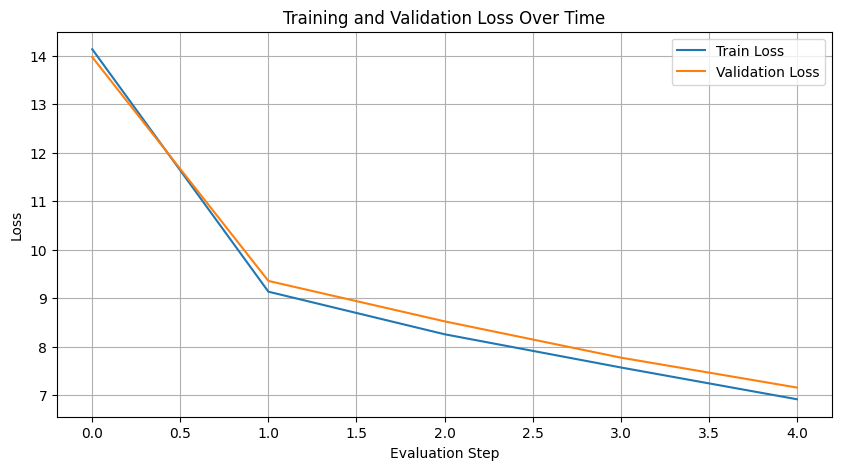

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

### 5. Inference

In [23]:
checkpoint_path = "../output/fine_tuning/qa/base/run_3/checkpoint_49.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

FileNotFoundError: [Errno 2] No such file or directory: '../output/fine_tuning/qa/base/run_3/checkpoint_49.pth'

In [25]:
def get_input_tokens(turns: list[dict]) -> list[int]:
    formatted_input = ""
    for turn in turns:
        role = turn["role"]
        content = turn["content"]
        formatted_input += f"{tokens['start']}{role}{tokens['separator']}{content}{tokens['end']}"

    formatted_input += f"{tokens['start']}assistant{tokens['separator']}"

    input_tokens = tokenizer.encode(formatted_input, allowed_special="all")
    input_tokens = torch.tensor(input_tokens, dtype=torch.long)
    input_tokens = input_tokens.unsqueeze(0).to(device)
    return input_tokens


def get_generated_message(input_tokens: list[int]) -> str:
    model_answer = ""
    model.eval()
    while True:
        try:
            output_tokens = model.advanced_generation(
                input_tokens=input_tokens, max_new_tokens=1, temperature=.9, top_k=50, top_p=None)
            last_generated_token = output_tokens[0, -1].item()
            if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
                break

            if last_generated_token == tokenizer.special_tokens["<|end_turn|>"]:
                break

            input_tokens = torch.cat(
                (input_tokens, output_tokens[:, -1:]), dim=1)
            model_answer += tokenizer.decode([last_generated_token])

            if len(output_tokens[0]) > block_size:
                break
        except Exception:
            continue

    return model_answer


user_message = "Hola, ¿cómo estás?"
turns = [
    {
        "role": "system",
        "content": system_message
    },
    {
        "role": "user",
        "content": user_message
    },
]
input_tokens = get_input_tokens(turns=turns)
model_answer = get_generated_message(input_tokens=input_tokens)
turns.append({
    "role": "assistant",
    "content": model_answer
})

for turn in turns:
    role = turn["role"]
    if role == "user":
        print(f"You: {turn['content']}")
    elif role == "assistant":
        print(f"Assistant: {turn['content']}")

KeyboardInterrupt: 

In [ ]:
# turns = turns[:-2]  # Uncomment this if you want to retry the generation
user_message = "شحال من دقيقة كاينة فالنهار؟"
turns.append({
    "role": "user",
    "content": user_message
})
input_tokens = get_input_tokens(turns=turns)
model_answer = get_generated_message(input_tokens=input_tokens)
turns.append({
    "role": "assistant",
    "content": model_answer
})
for turn in turns:
    role = turn["role"]
    if role == "user":
        print(f"You: {turn['content']}")
    elif role == "assistant":
        print(f"Assistant: {turn['content']}")

In [ ]:
# turns = turns[:-2] # Uncomment this if you want to retry the generation
user_message = "اللعز الله يحفضك."
turns.append({
    "role": "user",
    "content": user_message
})
input_tokens = get_input_tokens(turns=turns)
model_answer = get_generated_message(input_tokens=input_tokens)
turns.append({
    "role": "assistant",
    "content": model_answer
})
for turn in turns:
    role = turn["role"]
    if role == "user":
        print(f"You: {turn['content']}")
    elif role == "assistant":
        print(f"Assistant: {turn['content']}")

You: شنو سميتك؟
Assistant: بودماغ، كاين شي حاجة نعاونك بها؟
You: شحال من دقيقة كاينة فالنهار؟
Assistant: فالعالم كاين تقريبا 1440 دقيقة فالنهار.
You: اللعز الله يحفضك.
Assistant: الى عندك شي سؤال خور غولهالي.
